In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from tqdm.auto import trange

import time
import pickle
import csv
import os
import logging

In [2]:
global grid_3d, dims, beta, j_matrix, j_matrix_array, h, delta

In [3]:
def parameters_init(dims_init, beta_init, h_init):
    global grid_3d, dims, beta, h
    dims = (nb.int64(dims_init[0]), nb.int64(dims_init[1]), nb.int64(dims_init[2]))
    beta, h = nb.float64(beta_init), nb.float64(h_init)
    grid_3d = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                           size=dims_init[0]*dims_init[1]*dims_init[2]), 
                                           dims_init)

In [4]:
def j_matrix_2d():
    num_j = 6
    j_matrix = np.zeros((dims[1], dims[2], num_j), dtype=np.int8)
    for i in range(dims[1]):
        for j in range(dims[2]):
            j_matrix[i][j] = (-1) ** np.random.binomial(1, 1/2, num_j)
    for i in range(dims[1]):
        for j in range(dims[2]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[1]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[2]][2]    
    return j_matrix

In [5]:
def j_matrix_3d():
    global j_matrix_array
    j_matrix_list = []
    num_layers = dims[0]
    j_matrix = j_matrix_2d()
    j_matrix_list.append(j_matrix)
    j_matrix = j_matrix_2d()
    for i in range(dims[1]):
        for j in range(dims[2]):
            j_matrix[i][j][-2] = j_matrix_list[-1][i][j][-1]
    j_matrix_list.append(j_matrix)
    for _ in range(2, num_layers):
        j_matrix = j_matrix_2d()
        for i in range(dims[1]):
            for j in range(dims[2]):
                j_matrix[i][j][-2] = j_matrix_list[-1][i][j][-1]
        j_matrix_list.append(j_matrix)
    j_matrix_array = np.array(j_matrix_list)

In [6]:
########################################################################################
### initialize the parameters
dims_init = (16, 16, 16)
beta_init, h_init = 5, 0
parameters_init(dims_init, beta_init, h_init)
j_matrix_3d()

In [7]:
types_neibor_get = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 3), 6)(nb.types.UniTuple(nb.int8, 3))
@nb.cfunc(types_neibor_get)
def neibor_get_3d(id_grid):
    height, width, layers = dims
    height_index, width_index, layer_index = id_grid
    l_neibor = (layer_index, height_index, (width_index - 1) % width)
    r_neibor = (layer_index, height_index, (width_index + 1) % width)
    u_neibor = (layer_index, (height_index - 1) % height, width_index)
    d_neibor = (layer_index, (height_index + 1) % height, width_index)  
    left_neibor = ((layer_index - 1) % layers, height_index, width_index)
    right_neibor = ((layer_index + 1) % layers, height_index, width_index) 
    return (l_neibor, d_neibor, r_neibor, u_neibor, left_neibor, right_neibor)

In [8]:
types_energy_compute_one_grid = nb.int64(nb.int8[:, :, :], nb.types.UniTuple(nb.int8, 3), nb.int8)
@nb.njit(types_energy_compute_one_grid)
def energy_compute_one_grid_3d(grid_3d, id_grid, id_spin):
    energy_one_site = 0
    id_neibors = neibor_get_3d(id_grid)
    id_layer, id_row, id_col = id_grid
    if id_layer == dims[0] - 1:
        j_vec_left = j_matrix_array[id_layer-1]
        id_spin_left = grid_3d[id_layer-1][id_row][id_col]
        energy_one_site = energy_one_site + (-id_spin * id_spin_left * j_vec_left[id_row][id_col][-1])
    elif id_layer == 0:
        j_vec_right = j_matrix_array[id_layer+1]
        id_spin_right = grid_3d[id_layer+1][id_row][id_col]
        energy_one_site = energy_one_site + (-id_spin * id_spin_right * j_vec_right[id_row][id_col][-2])
    else:
        j_vec_left = j_matrix_array[id_layer-1]
        j_vec_right = j_matrix_array[id_layer+1]
        id_spin_right = grid_3d[id_layer+1][id_row][id_col]
        id_spin_left = grid_3d[id_layer-1][id_row][id_col]
        energy_one_site = energy_one_site - id_spin * id_spin_right * j_vec_right[id_row][id_col][-2]
        energy_one_site = energy_one_site - id_spin * id_spin_left * j_vec_left[id_row][id_col][-1]
    j_vec = j_matrix_array[id_layer][id_row][id_col]
    if id_row == 0:
        if id_col == 0:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row+1][id_col] * j_vec[1]
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col+1] * j_vec[2]
        elif id_col == dims[2] - 1:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col-1] * j_vec[0]
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row+1][id_col] * j_vec[1]
        else:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col-1] * j_vec[0]
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row+1][id_col] * j_vec[1]
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col+1] * j_vec[2] 
    elif id_row == dims[1] - 1:
        if id_col == 0:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col+1] * j_vec[2] 
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row-1][id_col] * j_vec[3] 
        elif id_col == dims[2] - 1:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col-1] * j_vec[0]
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row-1][id_col] * j_vec[3] 
        else:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col-1] * j_vec[0]
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col+1] * j_vec[2]             
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row-1][id_col] * j_vec[3] 
    elif id_col == 0:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row+1][id_col] * j_vec[1]            
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col+1] * j_vec[2]             
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row-1][id_col] * j_vec[3] 
    elif id_col == dims[2] - 1:
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col-1] * j_vec[0]        
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row+1][id_col] * j_vec[1]            
            energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row-1][id_col] * j_vec[3]  
    else:
        energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col-1] * j_vec[0]
        energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row+1][id_col] * j_vec[1]            
        energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row][id_col+1] * j_vec[2]             
        energy_one_site = energy_one_site - id_spin * grid_3d[id_layer][id_row-1][id_col] * j_vec[3] 
    return energy_one_site

In [9]:
@nb.njit(nb.float32(nb.int8[:, :, :]))
def energy_compute_grids(grid_3d):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            for kk in range(dims[2]):
                id_spin = grid_3d[ii][jj][kk]
                id_grid = (ii, jj, kk)
                energy_total += energy_compute_one_grid_3d(grid_3d, id_grid, id_spin)
    energy_per_spin = energy_total / (dims[0] * dims[1] * dims[2] * 2)
    return energy_per_spin

In [10]:
@nb.njit
def magnet_grids(grids):
    return np.mean(grids)

In [11]:
@nb.njit(nb.int8[:, :, :](nb.int8[:, :, :]))
def one_site_mcmc(grids):
    id_random = np.random.randint(dims[0]*dims[1]*dims[2])
    id_layer = nb.int8(id_random // (dims[1] * dims[2]))
    id_row = nb.int8(id_random % (dims[1] * dims[2]) // dims[1])
    id_col = nb.int8(id_random % (dims[1] * dims[2]) % dims[1])
    spin_old = grids[id_layer][id_row][id_col]
    spin_new = nb.int8(-1 * spin_old)
    id_grid = (id_layer, id_row, id_col)
    energy_old = energy_compute_one_grid_3d(grids, id_grid, spin_old)
    energy_new = energy_compute_one_grid_3d(grids, id_grid, spin_new)
    energy_delta = energy_new - energy_old
    if energy_delta <= 0:
        grids[id_layer][id_row][id_col] = spin_new
    else:
        prob_accept = np.exp(-beta * energy_delta)
        if np.random.random() < prob_accept:
            grids[id_layer][id_row][id_col] = spin_new
    return grids

In [12]:
@nb.njit(nb.int8[:, :, :](nb.int8[:, :, :]))
def one_step_mcmc(grids):
    for _ in range(dims[0]*dims[1]*dims[2]):
        grids = one_site_mcmc(grids)
    return grids

In [13]:
types_mcmc_func = nb.types.Tuple((nb.int8[:, :, :], nb.float64[:], nb.float64[:]))(nb.int8[:, :, :], nb.int64)
@nb.njit(types_mcmc_func)
def mcmc(grid_3d, steps):
    energy_history = np.zeros(steps, dtype=np.float64)
    m_history = np.zeros(steps, dtype=np.float64)
    for i in range(steps):
        grid_3d = one_step_mcmc(grid_3d)
        energy_per_spin = energy_compute_grids(grid_3d)
        m_per_spin = magnet_grids(grid_3d)
        energy_history[i] = energy_per_spin
        m_history[i] = m_per_spin
    return grid_3d, energy_history, m_history

-----------------------------------------

In [14]:
grid_3d.shape

(16, 16, 16)

In [15]:
### Burning-in stage
time_start = time.time()
#num_steps = 1
num_steps = 1000
grid_3d, energy_history, m_history = mcmc(grid_3d, num_steps)
time_end = time.time()

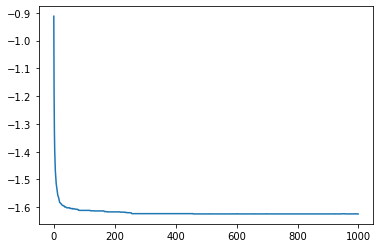

In [16]:
plt.plot(energy_history)

In [17]:
time_burn = time_end - time_start
print(f"Time used in burning-in stage ({num_steps}): {time_burn:.3f}.")

Time used in burning-in stage (1000): 1.694.


In [19]:
1.694 / 1000 * 25000000 / 3600 

11.76388888888889